## A) Importing libraries

In [1]:
#Basic imports

import pandas as pd
import numpy as np

#Data Visualization imports

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

#svd import
from scipy.sparse.linalg import svds

# Blocking warnings
import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_columns', None)

## B) List of Functions

In [20]:
#Recommender
def traditional_recommend_movies(preds_df, RANK, userID, movies_df, original_ratings_df, num_recommendations=20):
    
    # Get and sort the user's predictions
    user_row_number = RANK
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId',
               right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print (f'User {userID} has already rated {user_full.shape[0]} movies.')
    print (f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {RANK: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    # Calculating similarity score
    Users_similarity_score = preds_df.loc[RANK].T.reset_index()
    Users_similarity_score[[RANK]] = MinMaxScaler().fit_transform(Users_similarity_score[[RANK]])
    Users_similarity_score.rename(columns = {0:'similarity_score'}, inplace=True)
    already_rated_score = user_full.merge(Users_similarity_score, on='movieId', how='left')
    predictions_similarity_score = recommendations.merge(Users_similarity_score, on='movieId', how='left')

    #Storing results
    already_rated_score.to_csv(f'{userID}_comparison_already_rated_score.csv')
    predictions_similarity_score.to_csv(f'{userID}_comparison_predictions_similarity_score.csv')

    print('---------------------  Done  ---------------------')

    return already_rated_score, predictions_similarity_score

## C) Reading dataset and datacare

Splitting the database to identify the 10% top fuzzy c-means clusterized users of each user cluster (With the 80 of the sample included).

Recommending 20 movies for the same 80 users using ordinary recomendation system and comparing with sincere results.


In [ ]:
#Reading original dataframe
df_sincere = pd.read_csv('df_06d_sincere_database.csv')
df_sincere.drop('Unnamed: 0',axis=1, inplace = True)

In [5]:
#reading top 10 user sample for testing
top10 = pd.read_csv('users_sample_top10.csv', sep = ';')
top10 = list(top10['user_id'])
df_sincere = df_sincere.loc[df_sincere['userId'].isin(top10)]

#dropping unnused columns
df_sincere.drop(['user_cluster','movies_cluster_label'],axis=1, inplace = True)

#creating pivot table and adding a new list of ratings
df_ratings_pivot = df_sincere.pivot_table(values='rating', index='userId', columns='movieId').fillna(0)
df_ratings_list = df_sincere

#reseting index and filtering userId
user_clusters_filtered = df_ratings_pivot.reset_index()
user_clusters_filtered = user_clusters_filtered[['userId']]

## D) Using SVD and generating predictions

In [9]:
# Creating a de-mean matrix normalizing by each users mean and convert to a numpy array
ratings = df_ratings_pivot.values
user_ratings_mean = np.mean(ratings, axis = 1)
ratings_demeaned = ratings - user_ratings_mean.reshape(-1, 1)

# creating the matrices
U, sigma, Vt = svds(ratings_demeaned, k = 75) #SVD latent factor set to 75

# convert sigma to the diagonal matrix form
sigma = np.diag(sigma)

# Calculating the add the user means back
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

# Predicting user ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_ratings_pivot.columns)

In [12]:
# Df_movies full
df_movies = pd.read_csv('df_movies_sincere.csv')
df_movies.drop('Unnamed: 0',axis=1, inplace = True)
df_movies = df_movies[~(df_movies["movies_cluster_label"].isnull())]

In [ ]:
#list of users sample for testing
user_sample = [1612, 5153, 10595, 11377, 13079, 13148, 15806, 16656, 19936, 24522, 26046, 29021, 29054, 29518, 30509, 38768, 38955, 39657, 42473, 46134, 47153, 47280, 49561, 53614, 53968, 55828, 57499, 57569, 60615, 61869, 62199, 63203, 65721, 66751, 67762, 69434, 75236, 75408,77139, 77687, 79203, 79381, 84166, 86848, 87657, 87881, 88255, 89383, 99506, 100341, 100467, 100955, 104147, 104529, 106812, 107714,108486, 108743, 109013, 109600, 109744, 110289, 118620, 118906, 124413, 129711, 130311, 133610, 135548, 136484, 138165, 141766, 146893, 146925, 149358, 156183, 158270, 159734, 160743, 160747]

for user in user_sample:
    USER_ID = user
    RANK = user_clusters_filtered.index[user_clusters_filtered.userId == USER_ID][0]   
   
    # Adjusting Matrices to Predict
    coluna_lista = []
    for coluna in preds_df.columns:
        coluna_lista.append(int(coluna))
    preds_df.columns = coluna_lista
    preds_df.rename_axis('movieId', axis=1, inplace=True)

    # Calling the function to generate 5 predictions for each cluster
    already_rated_score, predictions_similarity_score = traditional_recommend_movies(preds_df, RANK, USER_ID, df_movies, df_ratings_list, 20)

In [23]:
#creating lists with saved files names
files_list_already_rated = []
files_list_recommendations = []

for user in user_sample:
    already = f'{user}_comparison_already_rated_score'
    files_list_already_rated.append(already)
    recommend = f'{user}_comparison_predictions_similarity_score'
    files_list_recommendations.append(recommend)

#grouping results of ordinary recommender system already rated
result_full_already_rated = pd.read_csv(f'{files_list_already[0]}.csv')
result_full_already_rated.drop('Unnamed: 0', axis=1, inplace=True)
result_full_already_rated.rename(columns = {result_full_already_rated.columns[-1]:'similarity_score'}, inplace=True)
result_full_already_rated['segment'] = 'comparison'
result_full_already_rated['Type'] = 'rated_by_user'

for result in files_list_already:
        results = pd.read_csv(f'{result}.csv')
        results.drop('Unnamed: 0', axis=1, inplace=True)
        results.rename(columns = {results.columns[-1]:'similarity_score'}, inplace=True)
        results['segment'] = 'comparison'
        results['Type'] = 'rated_by_user'
        result_full_already_rated = result_full_already_rated.append(results) 

#grouping results of ordinary recommender system recommendations
result_full_recommendations = pd.read_csv(f'{files_list_rec[0]}.csv')
result_full_recommendations.drop('Unnamed: 0', axis=1, inplace=True)
result_full_recommendations.rename(columns = {result_full_recommendations.columns[-1]:'similarity_score'}, inplace=True)
result_full_recommendations['userId'] = '1612'
result_full_recommendations['segment'] = 'comparison'
result_full_recommendations['Type'] = 'sincere_recommendation'

for result in files_list_rec:
        results = pd.read_csv(f'{result}.csv')
        results.drop('Unnamed: 0', axis=1, inplace=True)
        results.rename(columns = {results.columns[-1]:'similarity_score'}, inplace=True)
        results['userId'] = str(result).replace('_comparison_predictions_similarity_score',"").split("_")[0]
        results['segment'] = 'comparison'
        results['Type'] = 'sincere_recommendation'
        result_full_recommendations = result_full_recommendations.append(results)

#dropping duplicates generated by the function above
result_full_already_rated = result_full_already_rated.drop_duplicates(subset=['userId','movieId'])
result_full_recommendations = result_full_recommendations.drop_duplicates(subset=['userId','movieId'])

#filtering target columns
sincere_comparison_results = result_full_recommendations[['userId', 'movieId', 'imdbId', 'Title', 'Year', 'Genre', 'Director', 'Actors', 'Plot', 'Language', 'Country', 'imdbRating', 'Production', 'similarity_score', 'segment', 'Type']]
combined_comparison_results = result_full_already_rated[['userId', 'movieId', 'imdbId', 'Title', 'Year', 'Genre', 'Director', 'Actors', 'Plot', 'Language', 'Country', 'imdbRating', 'Production', 'similarity_score', 'segment', 'Type']]

#joining comparison results
combined_comparison_results = combined_comparison_results.append(sincere_comparison_results)

#saving to csv
combined_comparison_results.to_csv('result_comparison_topfuzzy.csv')

## E) Results comparison (Sincere vs Ordinary Recommender System)

In [ ]:
#reading df_ratings
df_ratings  = pd.read_csv('ratings.csv')

#generating sparsity index
movies_sparsity = df_ratings[['movieId', 'userId']].groupby('movieId').count()
movies_sparsity.reset_index()
movies_sparsity['sparsity'] =  1-(movies_sparsity['userId']/162541)
movies_sparsity.drop('userId',axis = 1, inplace = True)

In [52]:
#importing recommendations complete from sincere results
result_recommendations_complete = pd.read_csv('result_recommendations_complete.csv')

#importing comparison results
results_comparison = pd.read_csv('result_comparison_topfuzzy.csv')
results_comparison.drop('Unnamed: 0',axis=1, inplace=True)

#merging with movie sparsity and result recommendations
results_comparison = results_comparison.merge(movies_sparsity, on='movieId', how='left')
#results_comparison = results_comparison.merge(result_recommendations_complete, on= 'movieId', how='left')

#merging results with movie sparsity
result_recommendations_complete = result_recommendations_complete.merge(movies_sparsity, on='movieId', how='left')

#creating auxiliar table filtered with userID and user_cluster
result_recommendations = result_recommendations_complete[['userId', 'user_cluster']]
result_recommendations = result_recommendations.groupby('userId').mean()

#adding sincere clustering to result_recommendations
results_comparison = results_comparison.merge(result_recommendations, on='userId', how='left')


In [56]:
#filtering sincere results leaving only sincere recommendations
results = results_comparison.loc[results_comparison['Type'] == 'sincere_recommendation']

#selecting common columns to concat later
results = results[['user_cluster', 'userId', 'movieId', 'similarity_score', 'segment', 'Type', 'imdbRating','sparsity']]
result_recommendations_complete = result_recommendations_complete[['user_cluster', 'userId', 'movieId', 'similarity_score', 'segment', 'Type', 'imdbRating','sparsity']]

In [57]:
#creating new column for sincere results
result_recommendations_complete['source'] = 'sincere'

#creating new column for comparison results
results['source'] = 'comparison'

In [58]:
#dropping unnecessary columns
result_recommendations_complete.drop(['segment', 'Type'], axis = 1, inplace = True)
results.drop(['segment', 'Type'], axis = 1, inplace = True)

In [59]:
#concating results for plotting
results = pd.concat([results, result_recommendations_complete])

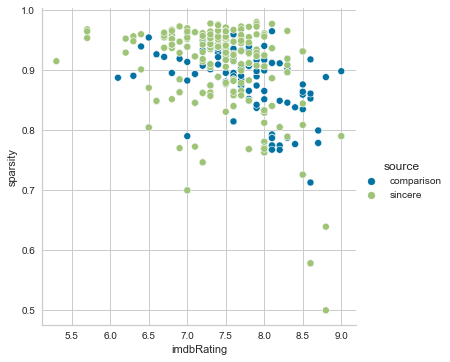

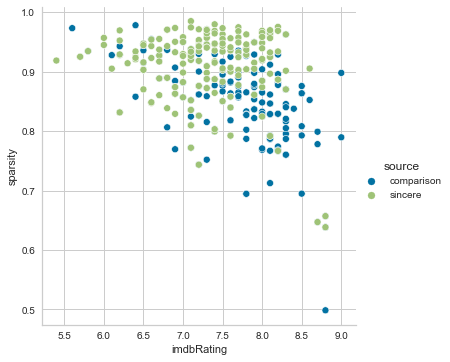

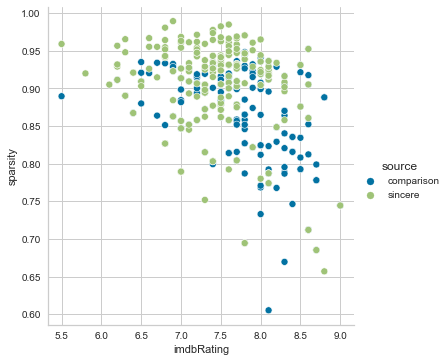

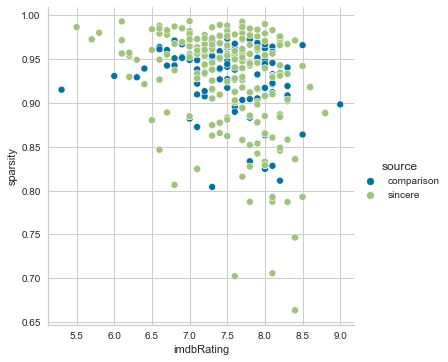

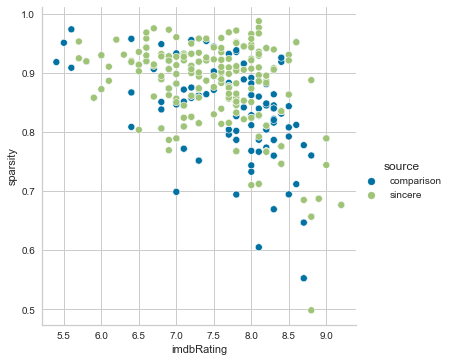

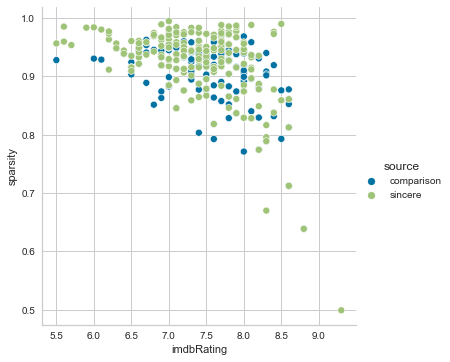

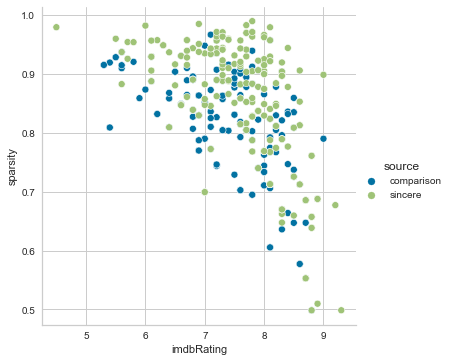

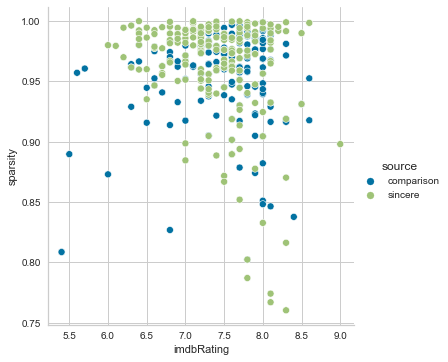

In [60]:
#generating graphs
user_cluster = [0,1,2,3,4,5,6,7] 

for cluster in user_cluster:
    data = results[results['user_cluster'].isin([cluster])]
    graph2 = sns.relplot(
    data=data, x="imdbRating", y="sparsity",
    hue="source",
    kind="scatter")
    #if you wish to save results remove # from the line below
    #graph2.savefig(f"Cluster_{cluster}_scatter_similarity_sparcity.png")